Modeling For Crypto Headlines:
--
Now, in this notebook I'll do some modeling to determine how well the headlines can help predict price movement in the crypto market.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn import tree

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import statsmodels.discrete.discrete_model as sm

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb
from xgboost import plot_tree
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('df_ready.csv')

In [3]:
# Need the target variable in 0 and 1 format, instead of as words

df['price_move'] = df['price_direction'].apply(lambda x: 1 if x == 'up' else 0)

In [4]:
df.dtypes

v2_headline        object
period_start       object
price_direction    object
price_move          int64
dtype: object

In [5]:
df = df.drop('price_direction', axis=1)

In [6]:
df.v2_headline = df.v2_headline.astype('U')

In [7]:
X = df.v2_headline
y = df.price_move

Train-Test Splitting:
--

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train = pd.DataFrame(X_train.todense(), columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test.todense(), columns=vectorizer.get_feature_names())

In [9]:
X_train

,abc,abound,abra,accelerated,accept,acceptance,accepting,accepts,accident,accounts,...,year,yearly,years,yes,yet,yield,yields,youtube,zero,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Baseline Model Performance:
--

In [10]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [11]:
dum_predictor = dummy_clf.predict(X_test)

In [12]:
dummy_clf.score(X_train, y_train)

0.4855769230769231

Function For Confusion Matrix:
--

In [13]:
def scoring(train, pred):
    
    accuracy = accuracy_score(train, pred)
    f1 = f1_score(train, pred)
    precision = precision_score(train, pred)
    recall = recall_score(train, pred)
    
    print(f'Accuracy score is: {accuracy}')
    print('---')
    print(f'F1 score is: {f1}')
    print(f'Precision score is: {precision}')
    print(f'Recall score is: {recall}')

In [14]:
scoring(y_test, dum_predictor)

Accuracy score is: 0.5128205128205128
---
F1 score is: 0.5189873417721519
Precision score is: 0.5942028985507246
Recall score is: 0.4606741573033708


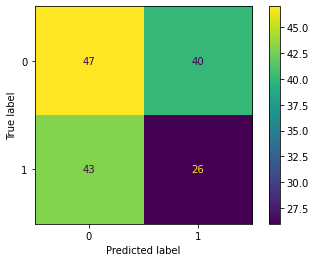

In [15]:
plot_confusion_matrix(dummy_clf, y_test, dum_predictor)  
plt.show()

Baseline Model: Logistic Regression
--

Using 'liblinear' because the dataset is quite small

In [16]:
log_reg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = log_reg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [17]:
log_test_preds = log_reg.predict(X_test)

In [18]:
scoring(y_test, log_test_preds)

Accuracy score is: 0.5705128205128205
---
F1 score is: 0.5732484076433122
Precision score is: 0.6617647058823529
Recall score is: 0.5056179775280899


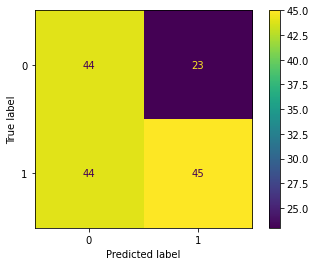

In [19]:
plot_confusion_matrix(log_reg, X_test, y_test)  
plt.show()

Random Forest: For Modeling & Feature Importance Discovery
--

In [20]:
forest = RandomForestClassifier(n_estimators=100)
forest_model = forest.fit(X_train, y_train)

In [21]:
forest_preds = forest_model.predict(X_test)

In [22]:
scoring(y_test, forest_preds)

Accuracy score is: 0.5256410256410257
---
F1 score is: 0.4477611940298507
Precision score is: 0.6666666666666666
Recall score is: 0.33707865168539325


<AxesSubplot:>

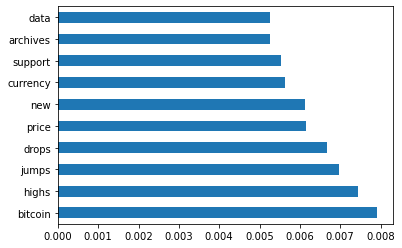

In [23]:
feat_impo = pd.Series(forest.feature_importances_, index=X_train.columns)
feat_impo.nlargest(10).plot(kind='barh')

Tuning The Number of Trees: 
--
Reducing to 25 estimators

In [24]:
forest25 = RandomForestClassifier(n_estimators=25)
forest_model25 = forest25.fit(X_train, y_train)

In [25]:
forest_preds25 = forest_model25.predict(X_test)

In [26]:
scoring(y_test, forest_preds25)

Accuracy score is: 0.5576923076923077
---
F1 score is: 0.5241379310344828
Precision score is: 0.6785714285714286
Recall score is: 0.42696629213483145


<AxesSubplot:>

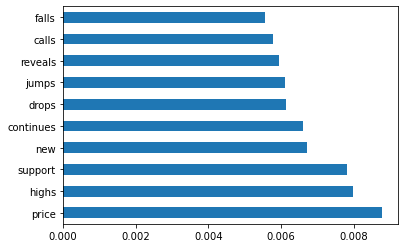

In [27]:
feat_impo25 = pd.Series(forest25.feature_importances_, index=X_train.columns)
feat_impo25.nlargest(10).plot(kind='barh')

Tuning Number of Trees:
--
Increasing the estimator number to 200

In [28]:
forest200 = RandomForestClassifier(n_estimators=200)
forest_model200 = forest200.fit(X_train, y_train)

In [29]:
forest_preds200 = forest_model200.predict(X_test)

In [30]:
scoring(y_test, forest_preds200)

Accuracy score is: 0.532051282051282
---
F1 score is: 0.45925925925925926
Precision score is: 0.6739130434782609
Recall score is: 0.34831460674157305


<AxesSubplot:>

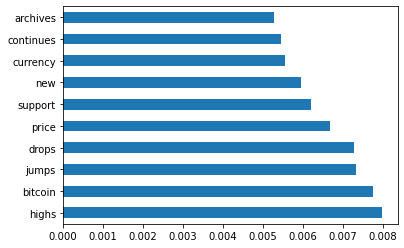

In [31]:
feat_impo200 = pd.Series(forest200.feature_importances_, index=X_train.columns)
feat_impo200.nlargest(10).plot(kind='barh')

Words "Bitcoin" and "Highs":
--
These two words are 1-2 respectively in terms of importance, remain so as estimators increase and seem to distance themselves from other words. But, this doesn't seem to make the model any more precise.

Will increase estimators again to check for whether this is the makings of a pattern

In [32]:
forest500 = RandomForestClassifier(n_estimators=500)
forest_model500 = forest500.fit(X_train, y_train)

In [33]:
forest_preds500 = forest_model500.predict(X_test)

In [34]:
scoring(y_test, forest_preds500)

Accuracy score is: 0.5448717948717948
---
F1 score is: 0.4817518248175182
Precision score is: 0.6875
Recall score is: 0.3707865168539326


Increase in Scoring with Increase in Estimators to 500
--

XGBoost: To Optimize The "Decision Trees" Angle
--
Now, I'll use XGBoost.

In [35]:
xgb_clf = xgb.XGBClassifier()

In [36]:
xgb_clf_model = xgb_clf.fit(X_train, y_train)

In [37]:
xgb_preds = xgb_clf.predict(X_test)

In [38]:
scoring(y_test, xgb_preds)

Accuracy score is: 0.46794871794871795
---
F1 score is: 0.29059829059829057
Precision score is: 0.6071428571428571
Recall score is: 0.19101123595505617


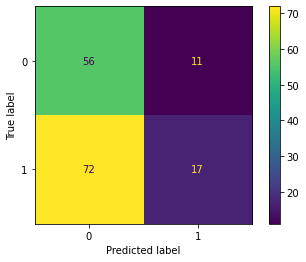

In [39]:
plot_confusion_matrix(xgb_clf_model, X_test, y_test)  
plt.show()

Logistic Regression Outperforms XGBoost
--
So far, Log-Reg produces the best Precision score while also maintaining the best Recall and F1 scores.

Returning Back to CountVectorizer: Parameter Tuning
--
Now, I'll go back to the Count Vectorizer step, to change how many vectors are included. Perhaps this will improve the Precision score (as well as other important scores)

In [40]:
X2 = df.v2_headline
y2 = df.price_move

In [41]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

vectorizer2 = CountVectorizer(max_features=500)
X_train2 = vectorizer2.fit_transform(X_train2)
X_test2 = vectorizer2.transform(X_test2)

X_train2 = pd.DataFrame(X_train2.todense(), columns=vectorizer2.get_feature_names())
X_test2 = pd.DataFrame(X_test2.todense(), columns=vectorizer2.get_feature_names())

In [42]:
X_train2

,accept,accepts,across,add,adds,affect,ahead,aim,allows,altcoins,...,whales,works,worst,worth,wrong,xlm,xrp,year,yearly,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
dummy_clf2 = DummyClassifier(strategy = 'stratified')
dummy_clf2.fit(X_train2, y_train2)

DummyClassifier(strategy='stratified')

In [44]:
dum_predictor2 = dummy_clf2.predict(X_test2)

In [45]:
dummy_clf2.score(X_train2, y_train2)

0.5160256410256411

In [46]:
scoring(y_test2, dum_predictor2)

Accuracy score is: 0.5128205128205128
---
F1 score is: 0.4864864864864865
Precision score is: 0.5901639344262295
Recall score is: 0.41379310344827586


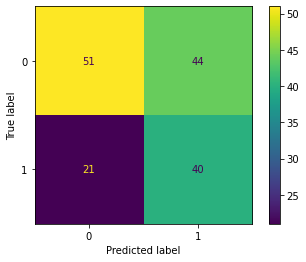

In [47]:
plot_confusion_matrix(dummy_clf2, y_test2, dum_predictor2)  
plt.show()

In [48]:
log_reg2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log2 = log_reg2.fit(X_train2, y_train2)
model_log2

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [49]:
log_test_preds2 = log_reg2.predict(X_test2)

In [50]:
scoring(y_test2, log_test_preds2)

Accuracy score is: 0.4935897435897436
---
F1 score is: 0.5536723163841807
Precision score is: 0.5444444444444444
Recall score is: 0.5632183908045977


Why Does The Model Performance Worsen???
--
The Logistic Regression model was best before with more Vectors. Now, it's performing worse than the dummmy classifier. Perhaps it's a matter of just having less data to work with? 

Running Random Forest Model:
--
Let's see if the same is true of Random Forest.

In [51]:
forest_too = RandomForestClassifier(n_estimators=100)
forest_model_too = forest_too.fit(X_train2, y_train2)

In [52]:
forest_preds_too = forest_model_too.predict(X_test2)

In [53]:
scoring(y_test2, forest_preds_too)

Accuracy score is: 0.47435897435897434
---
F1 score is: 0.5444444444444445
Precision score is: 0.5268817204301075
Recall score is: 0.5632183908045977


Now To Try XGBoost:
--
Before, XGBoost was worse than RF and LogR. What will be revealed now?

In [54]:
xgb_clf2 = xgb.XGBClassifier(max_depth=100)

In [55]:
xgb_clf_model2 = xgb_clf2.fit(X_train2, y_train2)

In [56]:
xgb_preds2 = xgb_clf2.predict(X_test2)

In [57]:
scoring(y_test2, xgb_preds2)

Accuracy score is: 0.4230769230769231
---
F1 score is: 0.39999999999999997
Precision score is: 0.47619047619047616
Recall score is: 0.3448275862068966


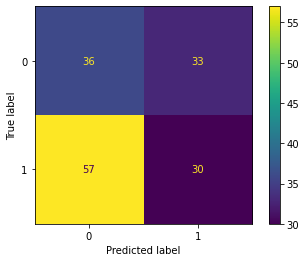

In [58]:
plot_confusion_matrix(xgb_clf_model2, X_test2, y_test2)  
plt.show()

In [59]:
xgb_clf3 = xgb.XGBClassifier(learning_rate=1, max_depth=100, min_child_weight=3, gamma=0)

In [60]:
xgb_clf_model3 = xgb_clf3.fit(X_train2, y_train2)

In [61]:
xgb_preds3 = xgb_clf3.predict(X_test2)

In [62]:
scoring(y_test2, xgb_preds3)

Accuracy score is: 0.4935897435897436
---
F1 score is: 0.33613445378151263
Precision score is: 0.625
Recall score is: 0.22988505747126436


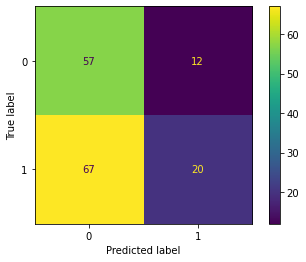

In [63]:
plot_confusion_matrix(xgb_clf_model3, X_test2, y_test2)  
plt.show()

With Some Parameter Tuning, Still Not Much Better than Guessing
--
So far, modeling on the vectors from the headlines are not showing much predictability beyond a simple guess.

3rd Train-Test Split: Reducing Vectors Further
--
Because the best method so far has been vector reduction, I will now reduce vectors further to determine whether this improves model performance.

In [64]:
X_third = df.v2_headline
y_third = df.price_move

In [65]:
X_train_third, X_test_third, y_train_third, y_test_third = train_test_split(X_third, y_third, test_size=0.2)

vectorizer_third = CountVectorizer(max_features=250)
X_train_third = vectorizer_third.fit_transform(X_train_third)
X_test_third = vectorizer_third.transform(X_test_third)

X_train_third = pd.DataFrame(X_train_third.todense(), columns=vectorizer_third.get_feature_names())
X_test_third = pd.DataFrame(X_test_third.todense(), columns=vectorizer_third.get_feature_names())

Dummy Classifier: Third Time
--
Since so far, the dummy classifier has performed better than my models even in many cases, I'll establish a baseline again.

In [66]:
dummy_clf_third = DummyClassifier(strategy = 'stratified')
dummy_clf_third.fit(X_train_third, y_train_third)

DummyClassifier(strategy='stratified')

In [67]:
dum_predictor_third = dummy_clf_third.predict(X_test_third)

In [68]:
scoring(y_test_third, dum_predictor_third)

Accuracy score is: 0.46794871794871795
---
F1 score is: 0.46451612903225803
Precision score is: 0.5070422535211268
Recall score is: 0.42857142857142855


In [69]:
log_reg_third = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log_third = log_reg_third.fit(X_train_third, y_train_third)
model_log_third

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [70]:
log_test_preds_third = log_reg_third.predict(X_test_third)

In [71]:
scoring(y_test_third, log_test_preds_third)

Accuracy score is: 0.5256410256410257
---
F1 score is: 0.4714285714285714
Precision score is: 0.5892857142857143
Recall score is: 0.39285714285714285


In [72]:
xgb_clf_third = xgb.XGBClassifier(learning_rate=1, max_depth=50, min_child_weight=1, gamma=0)

In [73]:
xgb_clf_model_third = xgb_clf_third.fit(X_train_third, y_train_third)

In [74]:
xgb_preds_third = xgb_clf_third.predict(X_test_third)

In [75]:
scoring(y_test_third, xgb_preds_third)

Accuracy score is: 0.5705128205128205
---
F1 score is: 0.633879781420765
Precision score is: 0.5858585858585859
Recall score is: 0.6904761904761905


Trying SVM
--


In [76]:
from sklearn import svm

In [77]:
clf = svm.SVC()
clf.fit(X_train2, y_train2)

SVC()

In [78]:
svm_pred = clf.predict(X_test2)

In [79]:
scoring(y_test2, svm_pred)

Accuracy score is: 0.5064102564102564
---
F1 score is: 0.5745856353591161
Precision score is: 0.5531914893617021
Recall score is: 0.5977011494252874


In [80]:
# taking one of ensemble models and doing a gridsearch on it -- pick 1 
# repetitive code, change to function
# Take a look at feature importances for final model
# for the top features, find out whether they occur more in positive or negative -- can be definitive
# EDA with pos-neg + up-down TargVar to visualize conclusion as well as top features

GridSearch with XGBoost:
--

In [81]:
# new train test split
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(X, y, test_size=0.2)

In [82]:
model_xgb = xgb.XGBClassifier()

In [83]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('model', model_xgb)
])

param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='precision')

In [84]:
grid.fit(X_train_gs, y_train_gs)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('model', XGBClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 5, 7, 10],
                         'model__n_estimators': [10, 100, 500]},
             scoring='precision')

In [85]:
grid.best_params_

{'model__max_depth': 7, 'model__n_estimators': 10}

In [86]:
grid.best_estimator_.named_steps['model'].feature_importances_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Re-Running XGBoost with Best Parameters:
--

In [88]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('model', xgb.XGBClassifier(max_depth=7, n_estimators=10))
])

In [89]:
pipeline.fit(X_train_gs, y_train_gs)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('model', XGBClassifier(max_depth=7, n_estimators=10))])

In [90]:
pipeline['count_vectorizer'].get_feature_names()

['abc',
 'abound',
 'abra',
 'accelerated',
 'accept',
 'acceptance',
 'accepting',
 'accepts',
 'accident',
 'accidents',
 'accounts',
 'across',
 'actually',
 'adamant',
 'add',
 'additional',
 'adds',
 'adjusted',
 'adjustment',
 'adoption',
 'advisors',
 'advocate',
 'afectado',
 'affect',
 'affecting',
 'affirms',
 'africa',
 'ahead',
 'aim',
 'aker',
 'akin',
 'alarms',
 'alcanza',
 'alert',
 'alibaba',
 'allocation',
 'allow',
 'allows',
 'almost',
 'along',
 'already',
 'alt',
 'altcoins',
 'alternative',
 'america',
 'american',
 'amid',
 'aml',
 'analysis',
 'analyst',
 'analysts',
 'analyzing',
 'ankit',
 'announces',
 'another',
 'answer',
 'anticipated',
 'anymore',
 'appeal',
 'appear',
 'application',
 'approaches',
 'apuesta',
 'arbitrum',
 'archives',
 'argo',
 'ark',
 'arm',
 'around',
 'arrival',
 'asian',
 'asset',
 'assets',
 'ath',
 'atms',
 'attack',
 'attacks',
 'attempt',
 'attention',
 'attract',
 'auction',
 'author',
 'authorities',
 'available',
 'average',

In [91]:
pipeline['model'].feature_importances_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [92]:
model_names = pipeline['count_vectorizer'].get_feature_names()

In [93]:
importances = pipeline['model'].feature_importances_

In [94]:
feats_zipped = list(zip(model_names, importances))

In [95]:
feats_zipped

[('abc', 0.0),
 ('abound', 0.0),
 ('abra', 0.0),
 ('accelerated', 0.0),
 ('accept', 0.0),
 ('acceptance', 0.0),
 ('accepting', 0.0),
 ('accepts', 0.0),
 ('accident', 0.0),
 ('accidents', 0.0),
 ('accounts', 0.0),
 ('across', 0.0),
 ('actually', 0.0),
 ('adamant', 0.0),
 ('add', 0.0),
 ('additional', 0.0),
 ('adds', 0.0),
 ('adjusted', 0.0),
 ('adjustment', 0.0),
 ('adoption', 0.0),
 ('advisors', 0.0),
 ('advocate', 0.0),
 ('afectado', 0.0),
 ('affect', 0.0),
 ('affecting', 0.0),
 ('affirms', 0.0),
 ('africa', 0.0),
 ('ahead', 0.0),
 ('aim', 0.0),
 ('aker', 0.0),
 ('akin', 0.0),
 ('alarms', 0.0),
 ('alcanza', 0.0),
 ('alert', 0.0),
 ('alibaba', 0.0),
 ('allocation', 0.0),
 ('allow', 0.0),
 ('allows', 0.0),
 ('almost', 0.0),
 ('along', 0.0),
 ('already', 0.0),
 ('alt', 0.0),
 ('altcoins', 0.0),
 ('alternative', 0.0),
 ('america', 0.0),
 ('american', 0.0),
 ('amid', 0.0),
 ('aml', 0.0),
 ('analysis', 0.0),
 ('analyst', 0.0),
 ('analysts', 0.0),
 ('analyzing', 0.0),
 ('ankit', 0.0),
 ('ann

In [96]:
fz_df = pd.DataFrame(feats_zipped, columns=['vectors','values'])

In [97]:
from xgboost import plot_importance

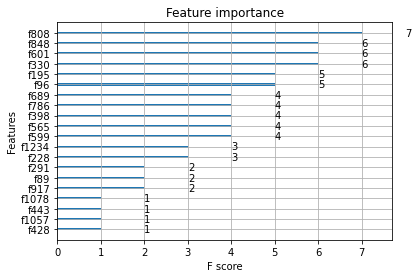

In [98]:
plot_importance(pipeline['model'], max_num_features=20)
plt.show()

In [99]:
top_fz = fz_df.sort_values(by=['values'], ascending=False)

In [289]:
top_fz

,vectors,values
808,million,0.059615
599,high,0.047508
330,currency,0.046586
601,highs,0.046355
565,grayscale,0.045089
...,...,...
477,fan,0.000000
475,fallacy,0.000000
474,fall,0.000000
473,fades,0.000000


In [101]:
# take headlines, sort according to pos or neg
# get word freq using nltk -- FreqDist
# maybe a word cloud for EDA
# but then can understand which direction the vectors go towards more

In [102]:
df

,v2_headline,period_start,price_move
0,altcoins potential next ethereum bitcoin,2017-07-03,1
1,bitcoin fan held sign testimony receives effort,2017-07-10,0
2,bitcoin fan holds sign receives donations effort,2017-10-30,0
3,bitcoin mining usb devices large usb,2017-10-30,0
4,word blockchain made bitcoin illustration,2017-10-30,0
...,...,...,...
775,cardano close launching smart charles hoskinson,2021-05-17,0
776,blockstream buys adamant expansion bitcoin inv...,2021-05-17,0
777,huobi scales back due china bitcoin falls ethe...,2021-05-17,0
778,ether last ath rout resumes,2021-05-17,0


In [168]:
# lambda <arguments> : <Return Value if condition is True> if <condition> else <Return Value if condition is False>

In [118]:
up_words = []
down_words = []

def sentimenter(headlines,movement):
    
    headlines.apply(lambda x: up_words.append(x) if movement.item() == 1 else down_words.append(x))

In [120]:
#sentimenter(df.v2_headline,df.price_move)

In [129]:
df.groupby('price_move')

In [132]:
df_directions = df.groupby('price_move')    
up_down_df = [df_directions.get_group(x) for x in df_directions.groups]

In [147]:
down_words = up_down_df[0]

In [140]:
up_words = up_down_df[1]

In [270]:
ups = ' '
ups = ups.join(up_words['v2_headline'].tolist())

In [274]:
downs = ' '
downs = downs.join(down_words['v2_headline'].tolist())

In [161]:
from nltk import FreqDist

In [278]:
fd_up = FreqDist(ups.split())
fd_down = FreqDist(downs.split())

In [279]:
fd_up

FreqDist({'bitcoin': 296, 'price': 35, 'new': 22, 'market': 20, 'says': 19, 'crypto': 18, 'btc': 15, 'high': 14, 'ethereum': 13, 'highs': 13, ...})

In [280]:
fd_down

FreqDist({'bitcoin': 287, 'price': 34, 'market': 20, 'says': 19, 'crypto': 16, 'ethereum': 16, 'mining': 14, 'btc': 12, 'could': 12, 'new': 10, ...})

In [284]:
! pip install wordcloud

In [285]:
from wordcloud import WordCloud

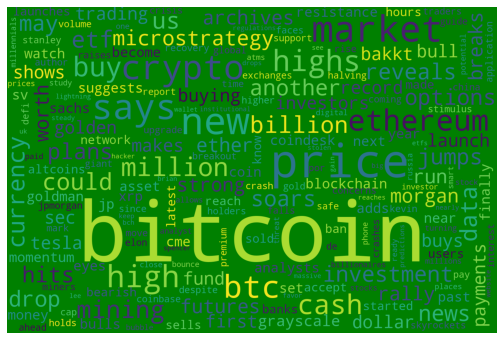

In [288]:
wordcloud = WordCloud(background_color='green',
                      width=1500,
                      height=1000
                      ).generate_from_frequencies(fd_up)

plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

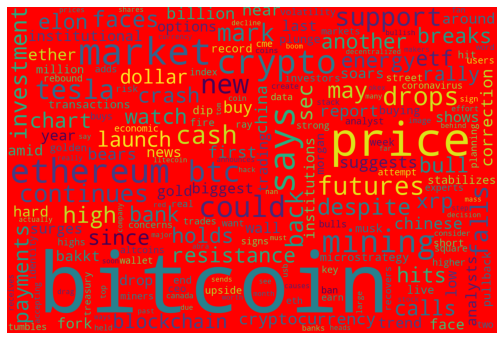

In [287]:
wordcloud = WordCloud(background_color='red',
                      width=1500,
                      height=1000
                      ).generate_from_frequencies(fd_down)

plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [297]:
top_fz_dict = top_fz.set_index('vectors').to_dict()['values']

In [298]:
top_fz_dict

{'million': 0.05961494520306587,
 'high': 0.04750770330429077,
 'currency': 0.04658575728535652,
 'highs': 0.0463552251458168,
 'grayscale': 0.04508880153298378,
 'mark': 0.04334826394915581,
 'support': 0.042920660227537155,
 'calls': 0.04258948564529419,
 'chart': 0.041466157883405685,
 'bank': 0.041369736194610596,
 'jumps': 0.04036245122551918,
 'drops': 0.039707548916339874,
 'run': 0.03912065178155899,
 'plans': 0.03882431611418724,
 'bears': 0.03874436393380165,
 'buy': 0.03802582249045372,
 'continues': 0.037714481353759766,
 'tesla': 0.037464503198862076,
 'back': 0.03715209662914276,
 'energy': 0.03617364913225174,
 'cryptocurrency': 0.03553594648838043,
 'reveals': 0.034617308527231216,
 'falls': 0.03407662361860275,
 'ethereum': 0.03193236142396927,
 'new': 0.02370111644268036,
 'possible': 0.0,
 'pressure': 0.0,
 'preparing': 0.0,
 'prepares': 0.0,
 'prepare': 0.0,
 'premium': 0.0,
 'posting': 0.0,
 'postponed': 0.0,
 'premine': 0.0,
 'predicts': 0.0,
 'prevent': 0.0,
 'pr

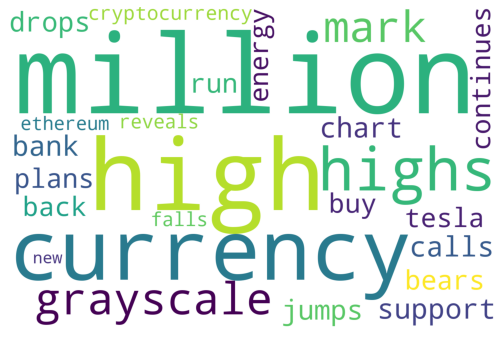

In [323]:
wordcloud = WordCloud(background_color='white',
                      width=1500,
                      height=1000
                      ).generate_from_frequencies(top_fz_dict)

plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Conclusion: A Good Beginning Albeit With Model Lacking Predictive Power
--

I was able to identify important words within the dataset that had the biggest impact on weekly price movement, even if there isn't a whole lot of reliability I can place on these just yet, due to a smaller-than-desirable dataset mainly. Nevertheless, what can be understood is which words have little predictive power, words such as "Bitcoin" and "price" words which were the two highest in terms of feature importance while doing modeling. 

Although these words were at the top of feature importance, they were not in terms of full predictive power, as the predictive power for both "up" and "down" price movement is important here. The words 'high' and 'highs' seemed to stand out as potentially powerful words, but as well, there are quite a number of action verbs on the list for words with the most impact on the weekly price movement.

This suggests that no matter if the market goes up or down, articles whose headlines placed emphasis on the body of content  / subject matter using action verbs have some potential predictive power.

Recommendations For Next Steps:
--
- Include significantly more headlines, from crypto and non-crypto publications
- Increase the amount of search words for selecting website links (in addition to the word "Bitcoin" which was used for this first iteration)
- Consider shifting from headlines to perhaps article summaries, meta descriptions, or something else
- Use Bitcoin price data itself along with the word 'Bitcoin' for this same project
- Perform deeper NLP analysis and modeling (i.e. Neural Networks NLP)
- Be more specific with time period for both articles and crypto market data, so as to potentially increase predictive power (i.e. articles from 2019 only in order to predict weekly price change in the year 2019 only)
- Change the target variable from "weekly price change" to "daily price change"